# Ranger Optimization + ImageWoof

This notebook will go over how to utilize the Ranger (RAdam + LookAhead) optimizer and a `fit_flat_cos` fit function to train on the ImageWoof dataset to recreate the results found in the ImageWoof competition.

In this notebook, I will show how to use the Ranger optimizer, create a scheduler to accomidate, and a custom mxresnet architechure utilizing a Simple Self Attention layer

First let's install the libraries. You need to restart your runtime after running this line

In [14]:
# !pip install Pillow --upgrade
#!pip install git+https://github.com/fastai/fastai_dev > /dev/null

# Fastai2 DataLoader

First let's create our `PipeLine`. For the competition we wanted to use size 448x448, so we will do so here.

In [125]:
%load_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.basics import defaults

In [113]:
!ls

data					ImageWoof_Ranger_RangerQH.ipynb
ImageWoof_fastai_vs_fastai2_dive.ipynb	models
ImageWoof_Ranger.ipynb			xresnet.py


In [208]:
#import pdb
#pdb.set_trace()
#src = untar_data(URLs.IMAGEWOOF)
src = Path('data/imagewoof/imagewoof')
items = get_image_files(src)
split_idx = GrandparentSplitter(valid_name='val')(items)

In [127]:
items

(#12954) [data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00048652.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00003690.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00024326.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00026475.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00012460.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00009818.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00047658.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00032563.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00041653.JPEG,data/imagewoof/imagewoof/val/n02096294/ILSVRC2012_val_00002549.JPEG...]

In [19]:
#import pdb; pdb.pm()

One nice thing we can do is actually use a dictionary of labels a transform so we can turn the ImageWoof classes into something readable to us. We'll use the `DataSource` (medium level API)

In [209]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

To do this, we pass in the `__getitem__` attribute function to our transforms for our `y`'s

In [210]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]
item_img_tfms = [ToTensor()]
#item_img_tfms = [ToTensor(), FlipItem(0.0), RandomResizedCrop(128, min_scale=0.35)]

#item_img_tfms = [ToTensor()]

Now we can create our `DataSource` object

In [211]:
dsrc = DataSource(items, tfms, splits=split_idx)

In [200]:
dsrc

(#12954) [(<fastai2.vision.core.PILImage image mode=RGB size=500x358 at 0x7F5F4FECFD30>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=500x375 at 0x7F5F4FECFCF8>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=333x500 at 0x7F5F4FECFBE0>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=500x375 at 0x7F5F4FECFD68>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=460x500 at 0x7F5F4FECF128>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=500x375 at 0x7F5F4FECFD30>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=500x333 at 0x7F5F4FECFD68>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=333x500 at 0x7F5F4FECF5F8>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=333x500 at 0x7F5F4FECFD30>, tensor(2)),(<fastai2.vision.core.PILImage image mode=RGB size=500x334 at 0x7F5F4FECFB38>, tensor(2))...]

Now let's make this into a databunch. We can pass in our transforms we want to occur after each item is brought up and after each  batch. We can also pass in `Cuda` to run our transforms on the GPU

In [212]:
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize(*imagenet_stats)]

In [215]:
#dbunch = dsrc.databunch(shuffle_train=False, after_item=item_img_tfms, after_batch=batch_tfms, bs=64)
dbunch = dsrc.databunch(shuffle_train=False, after_batch=batch_tfms+[AffineCoordTfm(size=128)], bs=64)
dbunch

Let's see what we are looking at:

In [216]:
dbunch.show_batch()

StopIteration: 

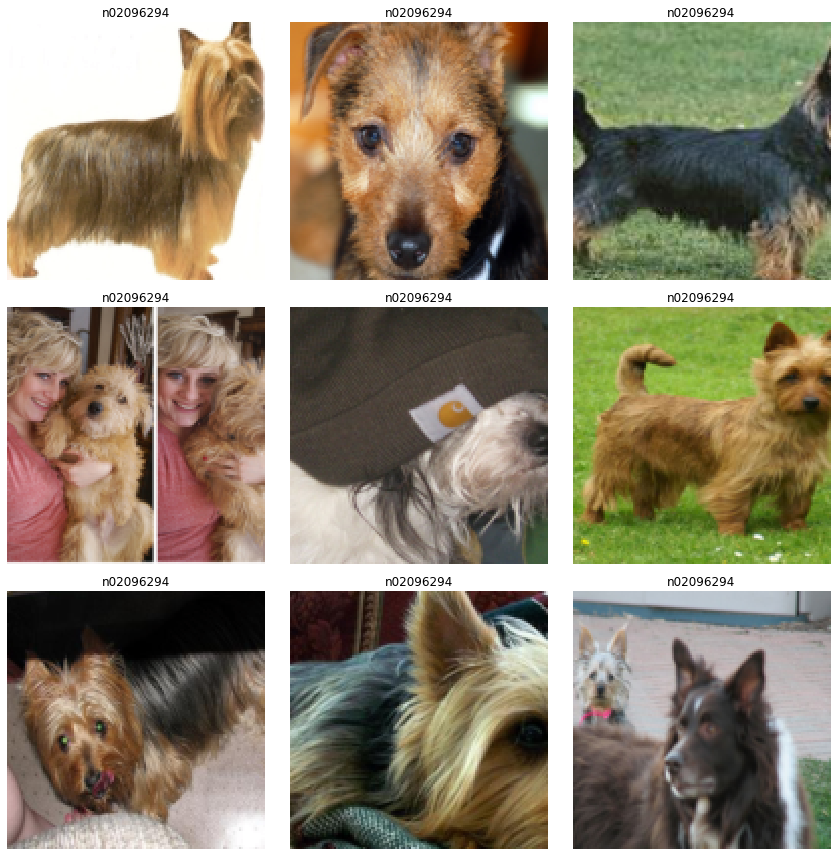

In [98]:
data.show_batch(3)

# Fastai v1

In [40]:
import os
os.getcwd() 

'/home/paperspace/Projects/ImageWoof_testing'

In [41]:
import sys
sys.path.append('~/anaconda3/pkgs/fastai-1.0.59-1/site-packages/fastai')

import fastai

In [154]:
from fastai.vision import *
n_gpus = num_distrib() or 1
nw = min(8, num_cpus()//n_gpus)

img_ls = ImageList.from_folder(src).split_by_folder(valid='val').label_from_folder()

img_ls = img_ls.transform(([flip_lr(p=0.0)], []), size=128)

data =img_ls.databunch(bs=64, num_workers=nw).normalize(imagenet_stats)

data.train_dl = data.train_dl.new(shuffle=False)

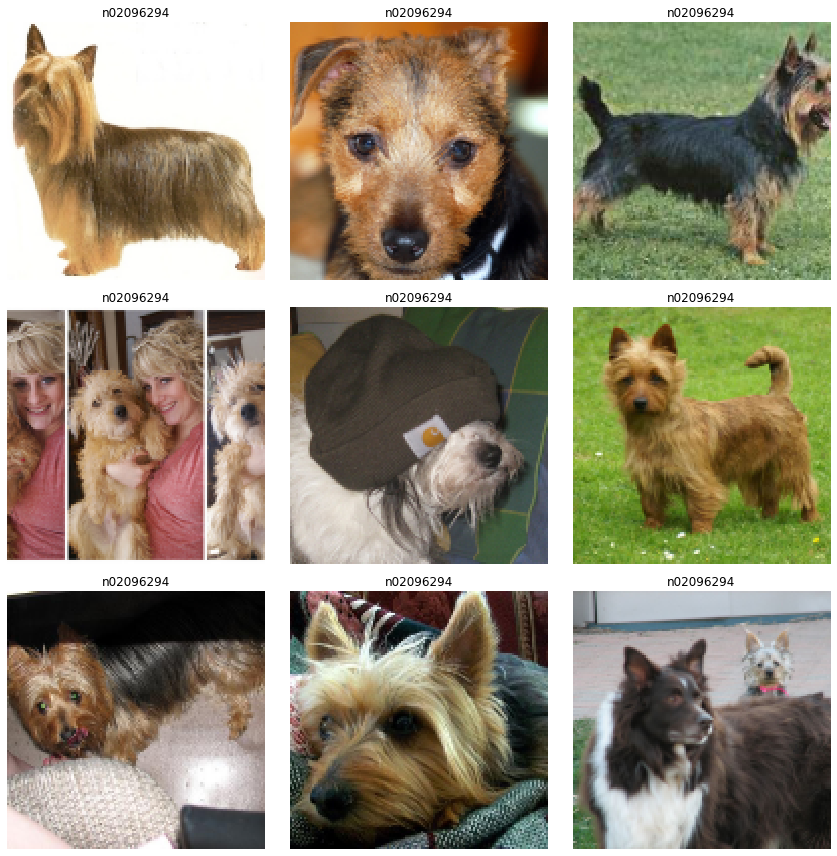

In [159]:
data.show_batch(3)

In [82]:
databunch.train_dl.dl.dataset.x.show_xys
databunch.train_dl.dl.dataset.

['n02086240',
 'n02087394',
 'n02088364',
 'n02089973',
 'n02093754',
 'n02096294',
 'n02099601',
 'n02105641',
 'n02111889',
 'n02115641']

In [93]:
databunch.train_dl.dl.dataset.x.items

array([PosixPath('data/imagewoof/imagewoof/train/n02096294/n02096294_79.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02096294/n02096294_5745.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02096294/n02096294_671.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02096294/n02096294_9025.JPEG'), ...,
       PosixPath('data/imagewoof/imagewoof/train/n02088364/n02088364_2690.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02088364/n02088364_15246.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02088364/n02088364_13464.JPEG'),
       PosixPath('data/imagewoof/imagewoof/train/n02088364/n02088364_12049.JPEG')], dtype=object)

# Custom Architecture

We will be using a standard xResnet50 along with replacing each ReLU activation function with a CUDA implemented version of Mish, and a Simple Self Attention Layer

The code for Mish is from TomB's repo [here](https://gist.github.com/thomasbrandon/0dce1b088cf0fb20023394228645b1c1)

In [14]:
# import torch
# import torch.nn.functional as F

# class Mish(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x): 
        
#         x = x *( torch.tanh(F.softplus(x)))

#         return x

### MishJit

In [64]:
@torch.jit.script
def mish_jit_fwd(x):
    return x.mul(torch.tanh(F.softplus(x)))


@torch.jit.script
def mish_jit_bwd(x, grad_output):
    x_sigmoid = torch.sigmoid(x)
    x_tanh_sp = F.softplus(x).tanh()
    return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


class MishJitAutoFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return mish_jit_fwd(x)

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        return mish_jit_bwd(x, grad_output)


def mish_jit(x, inplace=False):
    # inplace ignored
    return MishJitAutoFn.apply(x)


class MishJit(nn.Module):
    def __init__(self, inplace: bool = False):
        super(MishJit, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishJitAutoFn.apply(x)

Now we need to use sdoria's implementation of the SimpleSelfAttention layer in xresnet and adjust for an activation function

In [65]:
from fastai2.torch_core import *

import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from torch.nn.utils import spectral_norm 
from functools import partial

__all__ = ['XResNet', 'xresnet18', 'xresnet34', 'xresnet50', 'xresnet101', 'xresnet152']

# or: ELU+init (a=0.54; gain=1.55)
#act_fn = Mish()
act_fn = MishJit()


#Unmodified from https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)



# Adapted from SelfAttention layer at https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
# Inspired by https://arxiv.org/pdf/1805.08318.pdf
class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):#, n_out:int):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
        
        
        if self.sym:
            # symmetry hack by https://github.com/mgrankin
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)
                
        size = x.size()  
        x = x.view(*size[:2],-1)   # (C,N)
        
        # changed the order of mutiplication to avoid O(N^2) complexity
        # (x*xT)*(W*x) instead of (x*(xT*(W*x)))
        
        convx = self.conv(x)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())   # (C,N) * (N,C) = (C,C)   => O(NC^2)
        
        o = torch.bmm(xxT, convx)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
          
        o = self.gamma * o + x
        
          
        return o.view(*size).contiguous()        
        



class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False, sym=False):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.sa = SimpleSelfAttention(nf,ks=1,sym=sym) if sa else noop
        
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))
    

    

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

  
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, sa = False, sym= False):
        
        
        stem = []
        sizes = [c_in,32,64,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2, sa = sa if i in[len(layers)-4] else False, sym=sym)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, sa=False, sym=False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [blocks -1] else False,sym)
              for i in range(blocks)])

def xresnet(expansion, n_layers, name, pretrained=False,  **kwargs):
    model = XResNet(expansion, n_layers, **kwargs)
    if pretrained: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    return model

me = sys.modules[__name__]
for n,e,l in [
    [ 18 , 1, [2,2,2 ,2] ],
    [ 34 , 1, [3,4,6 ,3] ],
    [ 50 , 4, [3,4,6 ,3] ],
    [ 101, 4, [3,4,23,3] ],
    [ 152, 4, [3,8,36,3] ],
]:
    name = f'xresnet{n}'
    setattr(me, name, partial(xresnet, expansion=e, n_layers=l, name=name))

# Custom Fit Function

We have a new fit function for these new optimizers, called `fit_flat_cos`, and this is needed as the gradients were blowing up too fast with the one-cycle policy and it wasn't living up to what these new optimizers should be. So now, we begin at a flat learning rate, and then cosine anneal at the end of the cycle after about 72% or so

The code itself looks like so:

In [66]:
def fit_flat_cos(self:Learner, n_epoch, lr=None, div_final=1e5, pct_start=0.75, wd=defaults.wd,
                 cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` at flat `lr` before a cosine annealing."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr is None else lr)
    lr = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr, lr, lr/div_final)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [67]:
def FlatCosAnnealScheduler(self:Learner, lr:float=4e-3, tot_epochs:int=1, start_pct:float=0.72,
                           curve='cosine'):
    n = len(self.dbunch.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":        curve_sched=SchedCos(lr, 0)
    elif curve=="linear":      curve_sched=SchedLin(lr, 0)
    elif curve=="exponential": curve_sched=SchedExp(lr, 0)
    else: raiseValueError(f"annealing type not supported {curve}")
    scheds = [SchedNo(lr, start_pct), curve_sched]
    scheds = {'lr': combine_scheds([start_pct, 1-start_pct], scheds)}
    return scheds

def fit_fc(learn, tot_epochs:int=1, lr:float=1e-2, start_pct:float=0.72):
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr
    callbacks = ParamScheduler(FlatCosAnnealScheduler(learn, lr, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, cbs=callbacks)

We can see what it is doing by creating a `synth_learner` (synthetic learner)

In [15]:
from fastai2.test_utils import synth_learner

In [20]:
learn = synth_learner()

And then we can call a `fit`

In [21]:
learn.fit_flat_cos(10, pct_start=0.72)

epoch,train_loss,valid_loss,time
0,11.336455,11.079755,00:00
1,9.827239,7.587829,00:00
2,8.143019,4.767190,00:00
3,6.596681,2.876235,00:00
4,5.289625,1.695508,00:00
5,4.224703,0.987434,00:00
6,3.370444,0.579509,00:00
7,2.692340,0.353774,00:00
8,2.160854,0.267683,00:00
9,1.751263,0.254886,00:00


And if we report back our learning rate scheduler:

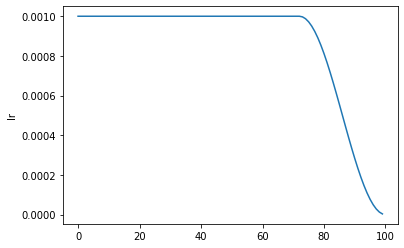

In [22]:
learn.recorder.plot_sched()

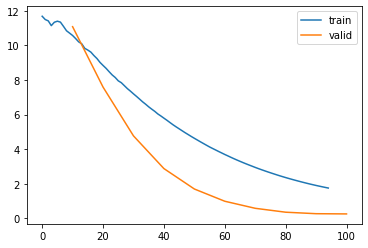

In [23]:
learn.recorder.plot_loss()

We can see that at 72% of our batches we begin to decrease our learning rate!

# Ranger Optimizer

The last bit needed is the Ranger optimization function. This was officially implemented into the v2 library as well, and it's quite easy to use! Ranger in itself is really RAdam + the LookAhead optimizer. As a result, in the fastai2 library the LookAhead optimizer is moduler (as it can be applied to any optimization function). Let's see how that looks like:

In [68]:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, wd=1e-2,mom=0.95, eps=1e-6,lr=lr))

Quite the easy one-liner! Now let's try putting this all together, our custom learning schedule, the optimizer, and our architecture

# Training!

Now first we can find our learning rate:

In [27]:
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)

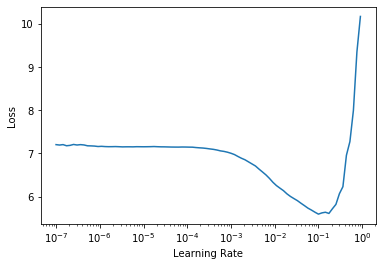

In [28]:
learn.lr_find()

As we can see, the ideal learning rate is around 4e-3. Let's fit for five epochs. During the competition it was seen that after five epochs we could get anywhere between 74.6 - 78%. Let's see how we can do!

In [31]:
fit_fc(learn, 5, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.657565,2.680168,0.336000,00:42
1,2.359644,2.399651,0.460000,00:40
2,2.168446,2.177712,0.564000,00:41
3,2.032825,2.078572,0.562000,00:41
4,1.814010,1.867134,0.680000,00:41


And that is how you use these new activation functions, learning scheme, and optimizers! Happy Learning! :)

## Full QHAdam Model

In [76]:
def qhadam_full_step(p, lr, mom, sqr_mom, sqr_avg, nus, step, grad_avg, eps, **kwargs):             
    nu_1 = nus[0]
    nu_2 = nus[1]
    
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    
    num = (((1-nu_1) * p.grad.data) + (nu_1 * (grad_avg / debias1)))
    denom = ( ((1 - nu_2) * (p.grad.data)**2) + (nu_2 * (sqr_avg / debias2))).sqrt() + eps 
                   
    p.data = p.data - lr * (numerator / denominator)
    return p           

In [61]:
def QHAdam_full(params, lr=1e-3, mom=0.9, sqr_mom=0.99, nus=[(.7, 1.0)], eps=1e-8, wd=0., decouple_wd=False):
    from functools  import partial
    steppers = [weight_decay] if decouple_wd else [l2_reg]
    steppers.append(qhadam_full_step)
    stats = [average_grad, average_sqr_grad, step_stat]
    return Optimizer(params, steppers, stats=stats, lr=lr, nus=nus, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

In [38]:
#def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.92, eps=1e-6))
def opt_func(ps, lr=defaults.lr): return QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.95, eps=1e-6)

In [35]:
del learn

In [41]:
#learn.purge;learn.destroy
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


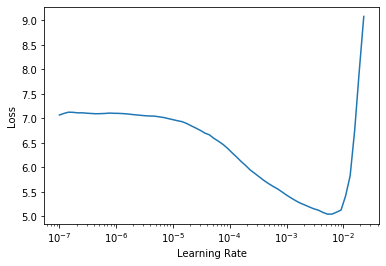

In [42]:
learn.lr_find()

In [43]:
learn.opt.clear_state()
fit_fc(learn, 5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.945381,2.896487,0.192000,00:40
1,2.689667,3.192329,0.200000,00:40
2,2.540391,2.700777,0.310000,00:41
3,2.405949,2.452229,0.438000,00:41
4,2.173460,2.162858,0.526000,00:41


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


lower lr

In [47]:
#learn.purge;learn.destroy
del learn
def opt_func(ps, lr=defaults.lr): return QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.95, eps=1e-6)

learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)

#learn.opt.clear_state()

fit_fc(learn, 5, 3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.732411,2.771136,0.330000,00:40
1,2.405553,2.483233,0.434000,00:40
2,2.232930,2.304539,0.478000,00:41
3,2.124250,2.220030,0.544000,00:41
4,1.937404,2.038792,0.612000,00:41


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


mom 0.97

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


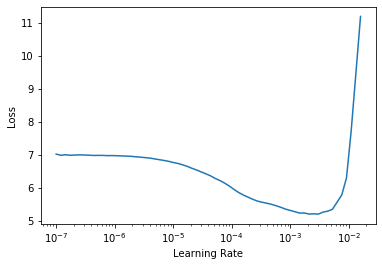

In [53]:
del learn
#learn.purge;learn.destroy
def opt_func(ps, lr=defaults.lr): return QHAdam_full(ps, lr=lr, wd=1e-2, mom=0.97, eps=1e-6)
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
#learn.opt.clear_state()
learn.lr_find()

In [59]:
def opt_func(ps, lr=defaults.lr): return QHAdam_full(ps, lr=lr, wd=1e-2, mom=0.97, eps=1e-6)
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.778182,2.780662,0.298000,00:41
1,2.492112,2.570313,0.382000,00:41
2,2.309251,2.421233,0.444000,00:41
3,2.170438,2.326697,0.482000,00:41
4,2.029370,2.164077,0.548000,00:42


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


In [54]:
learn.opt.clear_state()
fit_fc(learn, 5, 3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.707479,2.656235,0.336000,00:40
1,2.362048,2.512958,0.404000,00:41
2,2.223453,2.311014,0.510000,00:41
3,2.122409,2.238811,0.522000,00:41
4,1.934685,2.015788,0.600000,00:41


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


In [58]:
def opt_func(ps, lr=defaults.lr): return QHAdam_full(ps, lr=lr, wd=1e-2, mom=0.97, eps=1e-6)
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.814581,2.878411,0.246000,00:40
1,2.572258,2.784044,0.282000,00:40
2,2.425645,2.562897,0.394000,00:41
3,2.287790,2.238124,0.540000,00:41
4,2.058937,2.075609,0.588000,00:41


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


## RangerQH

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


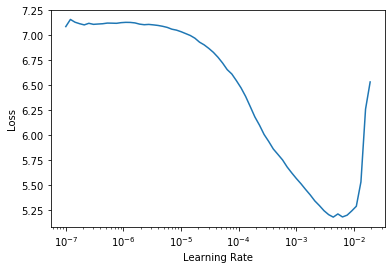

In [72]:
def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.95, eps=1e-6))
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
learn.lr_find()
del learn

In [70]:
def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.95, eps=1e-6))
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.702018,2.635175,0.318000,00:41
1,2.441459,2.814653,0.294000,00:42
2,2.276864,2.235640,0.554000,00:42
3,2.156212,2.137188,0.578000,00:42
4,1.911932,1.998897,0.644000,00:42


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


mom from 0.95 to 0.92

In [71]:
def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.92, eps=1e-6))
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.629231,2.659460,0.344000,00:41
1,2.345814,3.569220,0.246000,00:42
2,2.207036,2.180490,0.548000,00:42
3,2.096435,2.224075,0.502000,00:42
4,1.878315,1.921197,0.666000,00:42


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


mom from 0.95 to 0.90

In [75]:
def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.9, eps=1e-6))
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.627150,2.729182,0.302000,00:42
1,2.353805,3.008951,0.314000,00:42
2,2.204473,2.214357,0.556000,00:42
3,2.117248,2.123803,0.622000,00:42
4,1.884189,1.922917,0.674000,00:42


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


mom from 0.95 to 0.85

In [74]:
#del learn
def opt_func(ps, lr=defaults.lr): return Lookahead(QHAdam_full(ps, lr=lr, wd=1e-2,mom=0.85, eps=1e-6))
learn = Learner(dbunch, xresnet50(sa=True), opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
fit_fc(learn, 5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.638245,2.679652,0.372000,00:42
1,2.352219,2.714027,0.354000,00:42
2,2.205846,2.267556,0.518000,00:42
3,2.089815,2.423720,0.420000,00:42
4,1.884354,1.959634,0.644000,00:42


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
